# Visualizing the Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras

Using TensorFlow backend.


In [3]:
img = cv2.imread('resize/data_set/training_set/Dendrobium Antennatum/001.jpg')

In [4]:
img.shape

(84, 84, 3)

In [5]:
type(img)

numpy.ndarray

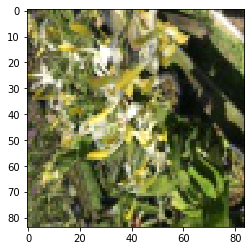

In [6]:
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(img)

# Generating images from a directory

In [7]:
image_gen = ImageDataGenerator(
    rotation_range=30, # rotate the image 30 degrees
    rescale=1/255, # Rescale the image by normalzing it.
    horizontal_flip=True, # Allo horizontal flipping
    fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)

In [8]:
batch_size = 16
image_shape = (84, 84, 3)

train_image_gen = image_gen.flow_from_directory('resize/data_set/training_set/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size)
test_image_gen = image_gen.flow_from_directory('resize/data_set/testing_set/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,shuffle=False)
validate_image_gen = image_gen.flow_from_directory('resize/data_set/validation_set/',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size)

Found 4800 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


# Create the Model

In [9]:
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Conv2D, MaxPooling2D

In [10]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

model.add(Dense(12,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 82, 82, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11552)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1478784   
_________________________________________________________________
dense_2 (Dense)              (None, 12)               

## Training the Model

In [12]:
train_image_gen.class_indices.keys()
train_image_gen.class_indices.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [13]:
#steps_per_epoch * batch_size = number_of_rows_in_train_data
#validation_steps - When the epoch ends, the validation generator will yield validation_steps batches

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = keras.callbacks.ModelCheckpoint('flower_classification.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

results = model.fit_generator(
    train_image_gen,epochs=25,
    steps_per_epoch=150,
    validation_data=validate_image_gen,
    validation_steps=12,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

Epoch 1/25
150/150 [==============================] - 22s 144ms/step - loss: 1.1935 - accuracy: 0.6025 - val_loss: 0.5712 - val_accuracy: 0.8333

Epoch 00001: val_loss improved from inf to 0.57122, saving model to flower_classification.h5
Epoch 2/25
150/150 [==============================] - 22s 145ms/step - loss: 0.4730 - accuracy: 0.8517 - val_loss: 0.4118 - val_accuracy: 0.9062

Epoch 00002: val_loss improved from 0.57122 to 0.41176, saving model to flower_classification.h5
Epoch 3/25
150/150 [==============================] - 22s 146ms/step - loss: 0.3469 - accuracy: 0.8888 - val_loss: 0.4321 - val_accuracy: 0.9115

Epoch 00003: val_loss did not improve from 0.41176
Epoch 4/25
150/150 [==============================] - 23s 154ms/step - loss: 0.2758 - accuracy: 0.9154 - val_loss: 0.4548 - val_accuracy: 0.9062

Epoch 00004: val_loss did not improve from 0.41176
Epoch 5/25
150/150 [==============================] - 20s 136ms/step - loss: 0.2342 - accuracy: 0.9179 - val_loss: 0.8908 - 

# Evaluating the Model

In [14]:
# from keras.models import load_model
# model = load_model('flower_classification.h5')

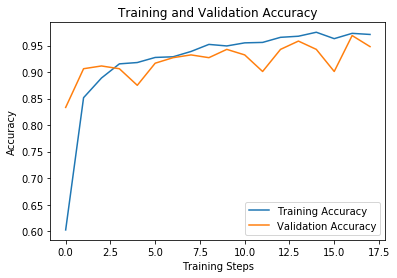

In [15]:
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

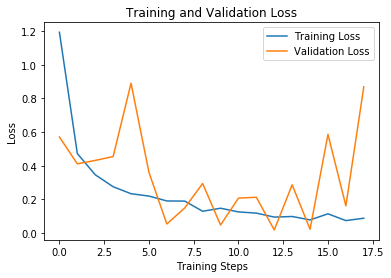

In [16]:
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Predicting The Data Set That Model Does Not See Before (Testing Set)

In [17]:
true_classes = test_image_gen.classes
class_labels = list(test_image_gen.class_indices.keys()) 

In [18]:
predictions = model.predict(test_image_gen)

In [19]:
predicted_classes = np.argmax(predictions, axis=1)

# Classification Report

In [20]:
from sklearn.metrics import classification_report,confusion_matrix,auc
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

                       precision    recall  f1-score   support

       Adenium Obesum       0.98      0.80      0.88       100
   Cattley Walkeriana       0.99      1.00      1.00       100
        Chrysanthemum       1.00      1.00      1.00       100
Dendrobium Antennatum       0.97      1.00      0.99       100
   Euphorbia Geroldii       0.92      0.91      0.91       100
      Ixora Chinensis       0.98      0.95      0.96       100
   Narrowleaf Angelon       0.93      1.00      0.96       100
                Orkid       0.86      0.97      0.91       100
            Pink Rose       1.00      1.00      1.00       100
       Red Frangipani       0.99      0.95      0.97       100
   Senna Bicapsularis       0.99      1.00      1.00       100
White Barberton Daisy       1.00      1.00      1.00       100

             accuracy                           0.96      1200
            macro avg       0.97      0.96      0.96      1200
         weighted avg       0.97      0.96      0.96 

# Confusion Matrix

In [21]:
con_matrix = confusion_matrix(true_classes, predicted_classes)

Text(0.5, 51.0, 'Predicted label')

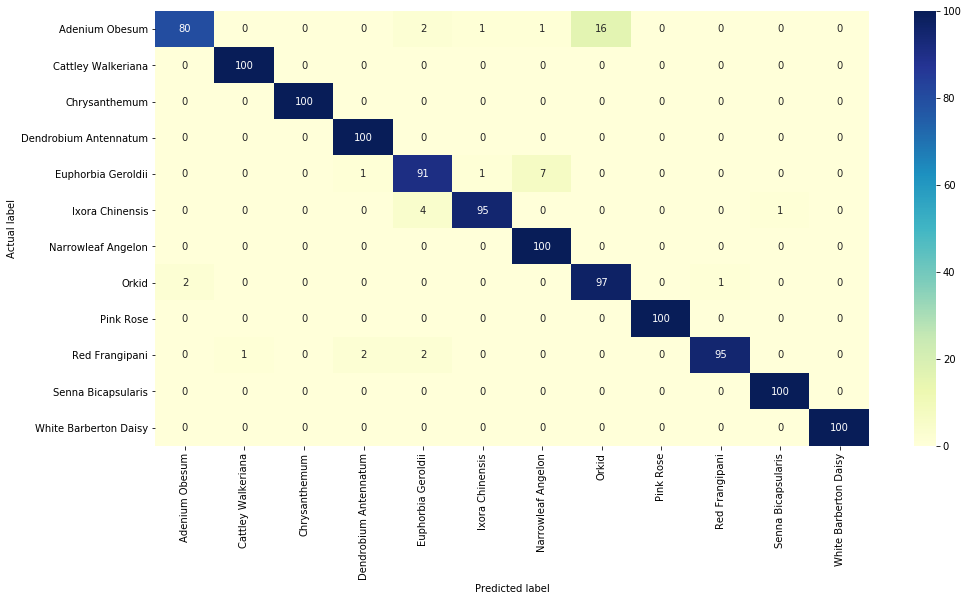

In [22]:
fig = plt.figure(figsize=(16,8))

sns.heatmap(pd.DataFrame(data=con_matrix,index=class_labels,columns=class_labels),annot=True,cmap="YlGnBu",fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize Prediction

In [23]:
train_image_gen.class_indices.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

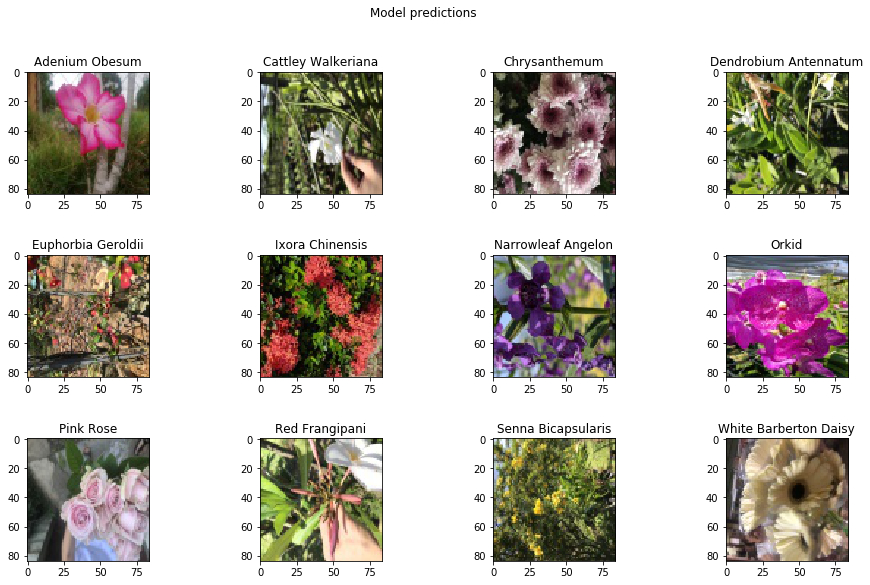

In [36]:
prediction_flower = list()
data = list()
def getRandomImage(text):
    for x in class_labels:     
        randNum = format(np.random.randint(1,50+1),'03')
        path = 'resize/data_set/testing_set/' + x + '/' + randNum + '.jpg'
        img = image.load_img(path,target_size=(84, 84))
        prediction_flower.append(img)
    getFigure(text)
    
def getFigure(text,color='black'):
    plt.figure(figsize=(16,9))
    plt.subplots_adjust(hspace=0.5)
    for n in train_image_gen.class_indices.values():
        plt.subplot(3,4,n+1)
        plt.imshow(prediction_flower[n])
        if data!=[]:
            color = "green" if n == data[n].argmax() else "red"
        plt.title(class_labels[n],color=color)
    _ =plt.suptitle(text)
getRandomImage("Model predictions")

In [42]:
data = list()
#copy and dont affect the orginal prediction_flowers
#rescale
prediction_flowers = prediction_flower[:]
for n in train_image_gen.class_indices.values():
    prediction_flowers[n] = image.img_to_array(prediction_flowers[n])
    prediction_flowers[n] = np.expand_dims(prediction_flowers[n], axis=0)
    prediction_flowers[n] = prediction_flowers[n]/255
for x in train_image_gen.class_indices.values():
    data.append(model.predict(prediction_flowers[x]))

data = np.squeeze(data, axis=0)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


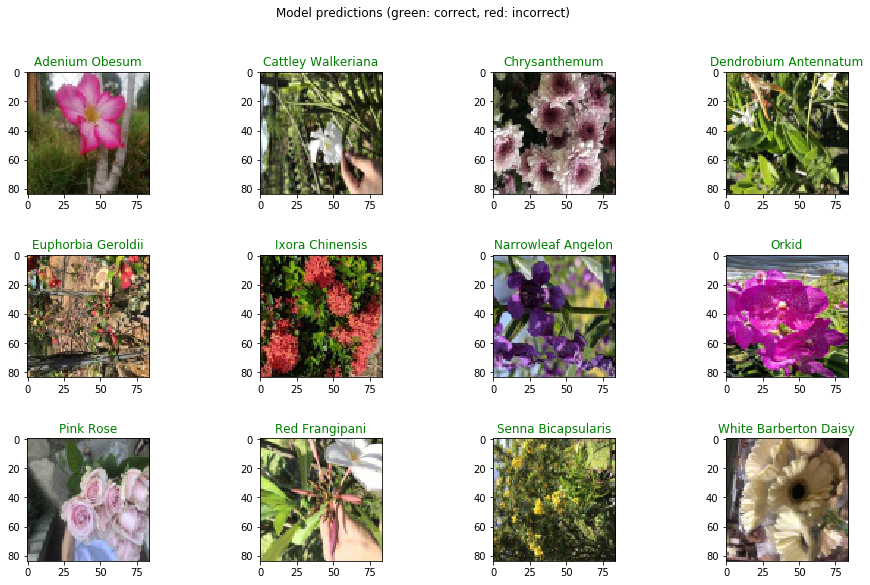

In [43]:
getFigure("Model predictions (green: correct, red: incorrect)")

Text(0.5, 51.0, 'Predicted label')

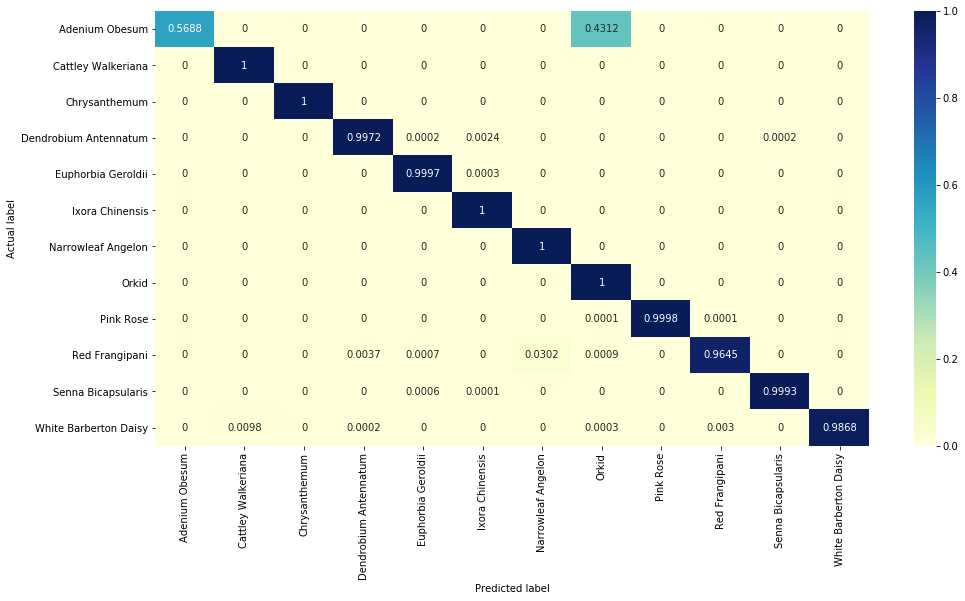

In [44]:
fig = plt.figure(figsize=(16,8))

sns.heatmap(pd.DataFrame(data=data.round(4),index=class_labels,columns=class_labels),annot=True,cmap="YlGnBu",fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [28]:
# model.save('flower_classification.h5')